In [ ]:
import os
import time
import cv2

In [ ]:
path_to_images = os.path.join('data','images')
images_taken = 4

In [ ]:
#cap = cv2.VideoCapture(0)
#for num in range(images_taken):
#    print('Snapping image {}'.format(num))
#    ret, frame = cap.read()
#    image_name = os.path.join(path_to_images, '.jpg')
#    cv2.imwrite(image_name, frame)
#    cv2.imshow('frame', frame)
#    time.sleep(0.5)

#    if cv2.waitKey(0) & 0xFF == ord('q'):
#        break

#cap.release()
#cv2.destroyAllWindows()

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
images = tf.data.Dataset.list_files('/content/images_data/images/*.jpg')

In [ ]:
images.as_numpy_iterator().next()

b'/content/images_data/images/2023-05-08-112739_4.jpg'

In [ ]:
def get_image(x):
  # returns a byte-encoded image
  byte_img = tf.io.read_file(x)

  # we decode the image and return it
  return tf.io.decode_jpeg(byte_img)

In [ ]:
images = images.map(get_image)

In [ ]:
#images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
# returns "batch_size" number of images
image_getter = images.batch(5).as_numpy_iterator()

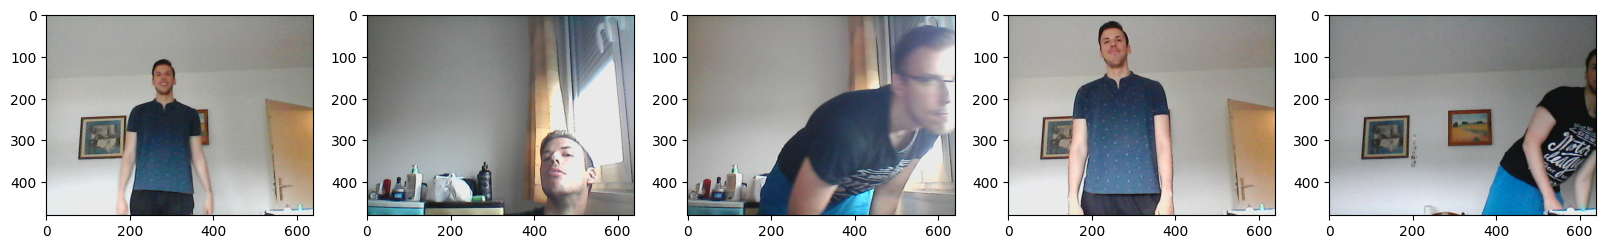

In [ ]:
show_images = image_getter.next()

fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(show_images):
  ax[idx].imshow(image)
plt.show()

In [ ]:
# Splitting the data to train, test, and validation partitions
# 60 to train, 16 to test, 16 to validation
# Done the splitting manually to ensure there is a proper variety of pictures in each partition

In [ ]:
for path in ['train', 'test', 'validation']:
  for file in os.listdir(os.path.join('/content/images_data', path, 'images')):
    file_name = file.split('.')[0] + '.json'
    label_filepath = os.path.join('/content/images_data', 'labeled_images', file_name)

    if os.path.exists(label_filepath):
      new_filepath = os.path.join('/content/images_data', path, 'labeled_images', file_name)
      os.replace(label_filepath, new_filepath)

In [ ]:
import albumentations as alb

In [ ]:
#image = cv2.imread(os.path.join('/content/images_data', 'images', '2023-05-08-111351_4.jpg'))

#image.shape

In [ ]:
image_augmentation = alb.Compose([alb.HorizontalFlip(p=0.5),
                                  alb.VerticalFlip(p=0.5),
                                  alb.RandomBrightnessContrast(p=0.2),
                                  alb.RGBShift(p=0.2),
                                  alb.RandomGamma(p=0.2),
                                  alb.RandomCrop(width=450, height=450)],
                                 bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [ ]:
rand_image = cv2.imread(os.path.join('/content/images_data', 'train', 'images', '2023-05-08-112546_4.jpg'))

In [ ]:
with open(os.path.join('/content/images_data', 'train', 'labeled_images', '2023-05-08-112546_4.json'), 'r') as f:
  image_label = json.load(f)

In [ ]:
image_label['shapes']

[{'label': 'Face :)',
  'points': [[324.1062801932367, 478.6473429951691],
   [218.79227053140102, 367.536231884058]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [ ]:
coordinates = [0,0,0,0]

coordinates[0] = image_label['shapes'][0]['points'][0][0]
coordinates[1] = image_label['shapes'][0]['points'][0][1]
coordinates[2] = image_label['shapes'][0]['points'][1][0]
coordinates[3] = image_label['shapes'][0]['points'][1][1]

coordinates

[324.1062801932367, 478.6473429951691, 218.79227053140102, 367.536231884058]

In [ ]:
coordinates = list(np.divide(coordinates, [640,480,640,480]))

coordinates

[0.5064160628019324,
 0.9971819645732689,
 0.3418629227053141,
 0.7657004830917875]

In [ ]:
tmp1 = coordinates[0]
tmp2 = coordinates[1]
coordinates[0] = coordinates[2]
coordinates[2] = tmp1

coordinates[1] = coordinates[3]
coordinates[3] = tmp2

In [ ]:
coordinates

[0.3418629227053141,
 0.7657004830917875,
 0.5064160628019324,
 0.9971819645732689]

In [ ]:
augmented_image = image_augmentation(image=rand_image, bboxes=[coordinates], class_labels=['Face :)'])

In [ ]:
augmented_image['bboxes']

[(0.3019860440150295, 0.0, 0.5360171765968867, 0.19214170692431556)]

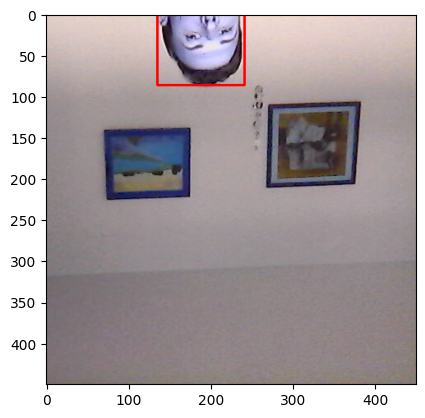

In [ ]:
cv2.rectangle(augmented_image['image'],
              tuple(np.multiply(augmented_image['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented_image['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented_image['image'])

In [ ]:
for partition in ['train', 'test', 'validation']:
  for image_path in os.listdir(os.path.join('/content/images_data', partition, 'images')):
    sample_image = cv2.imread(os.path.join('/content/images_data', partition, 'images', image_path))

    coordinates = [0, 0, 0.0001, 0.0001]
    label_path = os.path.join('/content/images_data', partition, 'labeled_images', f'{image_path.split(".")[0]}.json')
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        label = json.load(f)

        coordinates[0] = image_label['shapes'][0]['points'][0][0]
        coordinates[1] = image_label['shapes'][0]['points'][0][1]
        coordinates[2] = image_label['shapes'][0]['points'][1][0]
        coordinates[3] = image_label['shapes'][0]['points'][1][1]

        coordinates = list(np.divide(coordinates, [640,480,640,480]))
        x_min, y_min, x_max, y_max = coordinates[:4]
        if x_max <= x_min:
          coordinates[0], coordinates[2] = x_max, x_min
        if y_max <= y_min:
          coordinates[1], coordinates[3] = y_max, y_min

    try:
      for counter in range(60):
        augmented_image = image_augmentation(image=sample_image, bboxes=[coordinates], class_labels=['Face :)'])
        cv2.imwrite(os.path.join('/content/augmented_data', partition, 'images', f'{image_path.split(".")[0]}.{counter}.jpg'), augmented_image['image'])

        annotation = {}
        annotation['image'] = image_path

        if os.path.exists(label_path):
          if len(augmented_image['bboxes']) == 0:
            annotation['bbox'] = [0,0,0,0]
            annotation['class'] = 0
          else:
            annotation['bbox'] = augmented_image['bboxes'][0]
            annotation['class'] = 1
        else:
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0

        with open(os.path.join('/content/augmented_data', partition, 'labeled_images', f'{image_path.split(".")[0]}.{counter}.json'), 'w') as f:
          json.dump(annotation, f)

    except Exception as e:
      print(e)

In [ ]:
train_images = tf.data.Dataset.list_files('/content/augmented_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(get_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('/content/augmented_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(get_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('/content/augmented_data/validation/images/*.jpg', shuffle=False)
val_images = val_images.map(get_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
len(train_images)
#train.as_numpy_iterator().next()

3600

In [ ]:
def get_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [ ]:
train_labels = tf.data.Dataset.list_files('/content/augmented_data/train/labeled_images/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(get_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('/content/augmented_data/test/labeled_images/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(get_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('/content/augmented_data/validation/labeled_images/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(get_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
#len(train_labels)
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.5996, 0.7925, 0.834 , 1.    ], dtype=float16))

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 960, 960, 960, 960)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1100)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1100)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.502 , 0.    , 0.736 , 0.1943],
        [0.2084, 0.803 , 0.4424, 1.    ],
        [0.462 , 0.7725, 0.696 , 1.    ],
        [0.3442, 0.    , 0.578 , 0.1877],
        [0.5596, 0.803 , 0.794 , 1.    ],
        [0.3264, 0.7856, 0.5605, 1.    ],
        [0.6377, 0.    , 0.8716, 0.2054],
        [0.1951, 0.    , 0.4292, 0.2411]], dtype=float16))

In [ ]:
batch_sample = train.as_numpy_iterator()

In [ ]:
res = batch_sample.next()

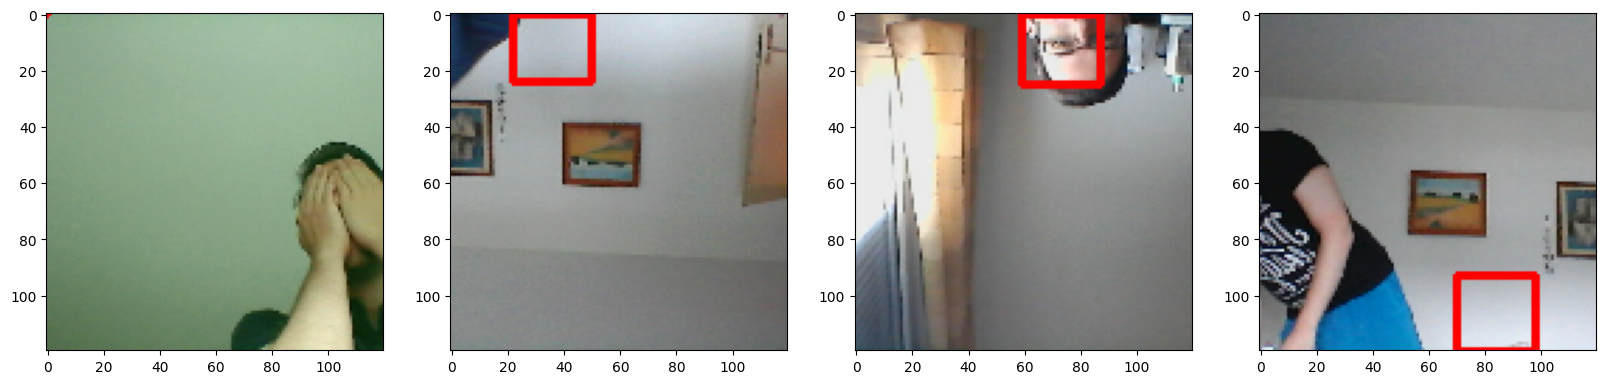

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [ ]:
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
#vgg.summary()

In [ ]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    return Model(inputs=input_layer, outputs=[class2, regress2])

In [ ]:
#train.as_numpy_iterator().next()[1]

In [ ]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [ ]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 4s 4s/step


(array([[0.5335232 ],
        [0.52811617],
        [0.44599304],
        [0.47296545],
        [0.47203583],
        [0.54018825],
        [0.45834804],
        [0.3814028 ]], dtype=float32),
 array([[0.71119255, 0.44172287, 0.4950867 , 0.3359339 ],
        [0.72101665, 0.37259045, 0.54454243, 0.3633935 ],
        [0.6910463 , 0.3979077 , 0.6390469 , 0.3887046 ],
        [0.6939256 , 0.40385643, 0.57408535, 0.36281204],
        [0.74316823, 0.4326878 , 0.494334  , 0.3660048 ],
        [0.7429864 , 0.3650029 , 0.6208705 , 0.40725386],
        [0.74551183, 0.41303495, 0.64231   , 0.33769292],
        [0.6763437 , 0.52498865, 0.6002549 , 0.3930952 ]], dtype=float32))

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
print(localization_loss(y[1], coords))
print(classloss(y[0], classes))
print(regressloss(y[1], coords))

tf.Tensor(3.9580183, shape=(), dtype=float32)
tf.Tensor(0.7416798, shape=(), dtype=float32)
tf.Tensor(3.9580183, shape=(), dtype=float32)
